<a href="https://colab.research.google.com/github/Lailamh/DSRP1/blob/main/DSRP_Written_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Emotional Evolution of Characters in *The Office* by Laila Hasan

To analyze the emotional development of the four main characters of *The Office*- Dwight, Jim, Michael, and Pam- I looked at their corresponding sentiment score for every line of dialogue they have. A sentiment score closer to 1 means that the line of dialogue was leaning towards the positive side, whereas a sentiment score closer to -1 indicates that their line of dialogue is relatively negative. By looking through the sentiment scores for each line of dialogue they have, I was able to find out whether that character is typically a positive or negative person. To further study their sentiment scores, I took their scores and looked at how they developed over the course of the show. To do this, I studied how their sentiment analysis scores fluctuate throughout the episodes they are in. One method I used for this was a t-test with a null hypothesis of: *the characters' sentiment score throughout the show doesn't change*. This resulted in all four characters having a p-value greater than 0.05, indicating that there is no significant change in their sentiment scores. To investigate these findings further, I developed a linear regression machine learning model for each of the four characters to visualize sentiment trends. The output of each model confirms the results of my t-test. However, Jim's sentiment scores showed a downward trend, while Michael's sentiment scores displayed a slightly upward trend.

*The Office*, a TV show from the early 2000s, has a very wide range of characters. Some are incredibly serious, whereas others are outright goofy. These traits play a major role in the characters' sentiment analysis score. Sparked from my interest in these sentiment scores, I formed the research question: *are certain characters associated more with positive or negative sentiment in The Office, and how does their associated sentiment score develop over time?*

In [2]:
# @title
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# @title
url = "https://raw.githubusercontent.com/dsollberger/quartoblog/master/posts/office_sentiment/office_sentiment.csv"
office_df = pd.read_csv(url)

In [4]:
# @title
#cleaning the data
office_df[office_df['sentimentAnalysis_score'].isnull()]
office_df['sentimentAnalysis_score'].unique()
office_df.loc[office_df['sentimentAnalysis_score'].isnull(), 'sentimentAnalysis_score'] = 'non-null values'
office_df = office_df[office_df['sentimentAnalysis_score'] != 0.0]

office_df['sentimentAnalysis_score'] = pd.to_numeric(office_df['sentimentAnalysis_score'], errors = 'coerce')
office_df['sentimentAnalysis_score'] = office_df.groupby('character')['sentimentAnalysis_score'].transform(
    lambda x: x.fillna(x.mean())
)
sentiment_median = office_df['sentimentAnalysis_score'].median()
office_df['sentimentAnalysis_score'] = office_df['sentimentAnalysis_score'].fillna(sentiment_median)
office_df['sentimentAnalysis_score'] = pd.to_numeric(office_df['sentimentAnalysis_score'], errors='coerce')

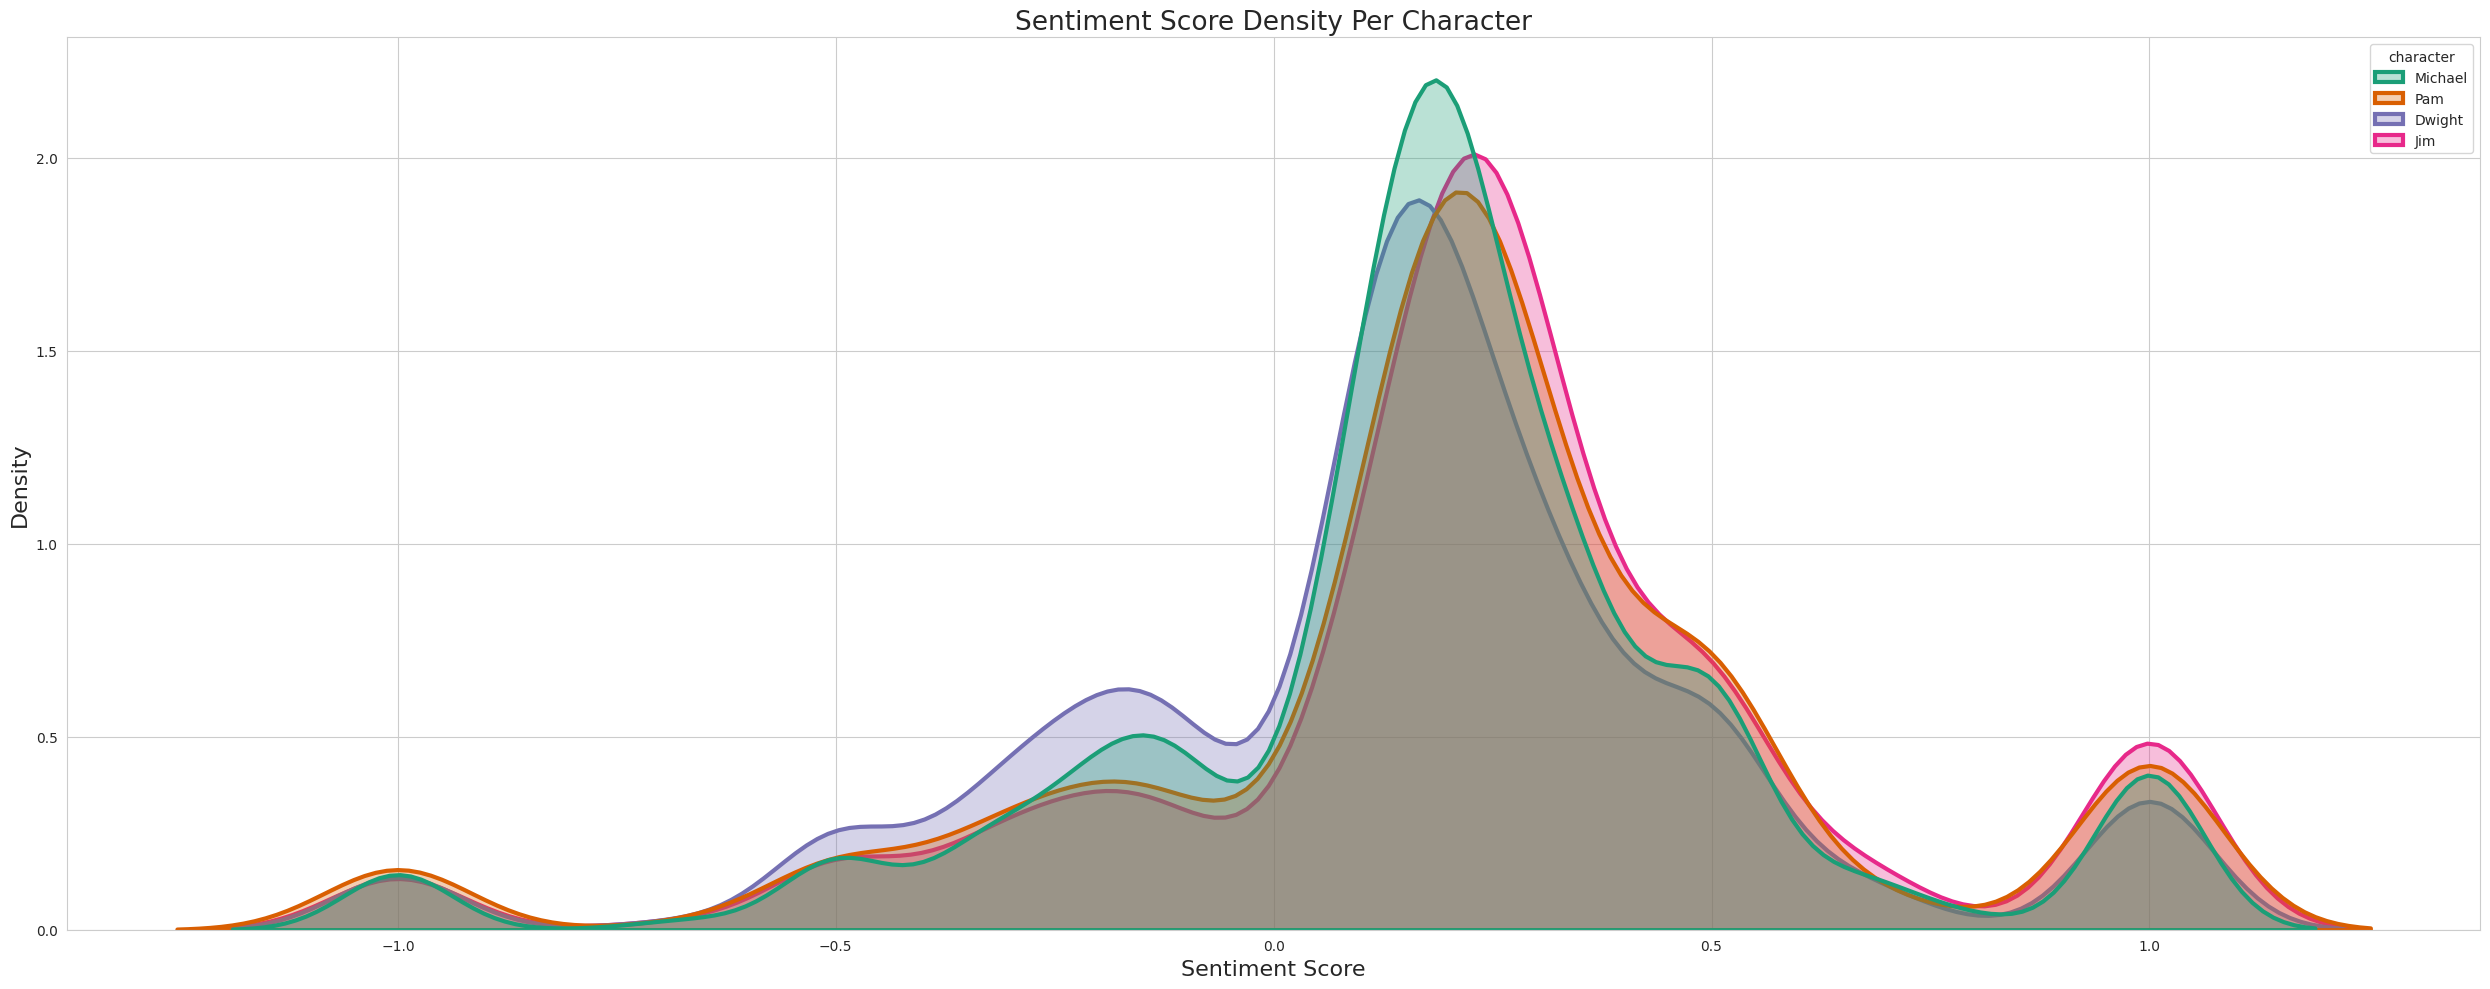

In [5]:
# @title
characters = ["Jim", "Pam", "Michael", "Dwight"]
characters_df = office_df[office_df['character'].isin(characters)]


characters_df['sentimentAnalysis_score'] = pd.to_numeric(characters_df['sentimentAnalysis_score'], errors = 'coerce')
plt.figure(figsize = (25, 10))
sns.set_style('whitegrid')
palette = sns.color_palette('Dark2')

sns.kdeplot(data = characters_df, x = 'sentimentAnalysis_score', hue = 'character', common_norm = False, fill = True, linewidth = 3, palette = palette, alpha = 0.3)
plt.title("Sentiment Score Density Per Character", fontsize = 19)
plt.xlabel("Sentiment Score", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.tight_layout()
plt.show()

                                                          Figure 1
Each of the 4 characters' sentiment analysis scores are shown in this density plot. The colored lines show the range of sentiment for Michael, Pam, Dwight, and Jim, whereas the dark green/grey color shows where their scores overlap. Looking at all four characters' modes, Michael's mode exceeds the other characters. All four characters' modes occur close to the same location, and since Michael's plot has the highest mode, he has more sentiment scores around the value of 0.2 than the other characters.

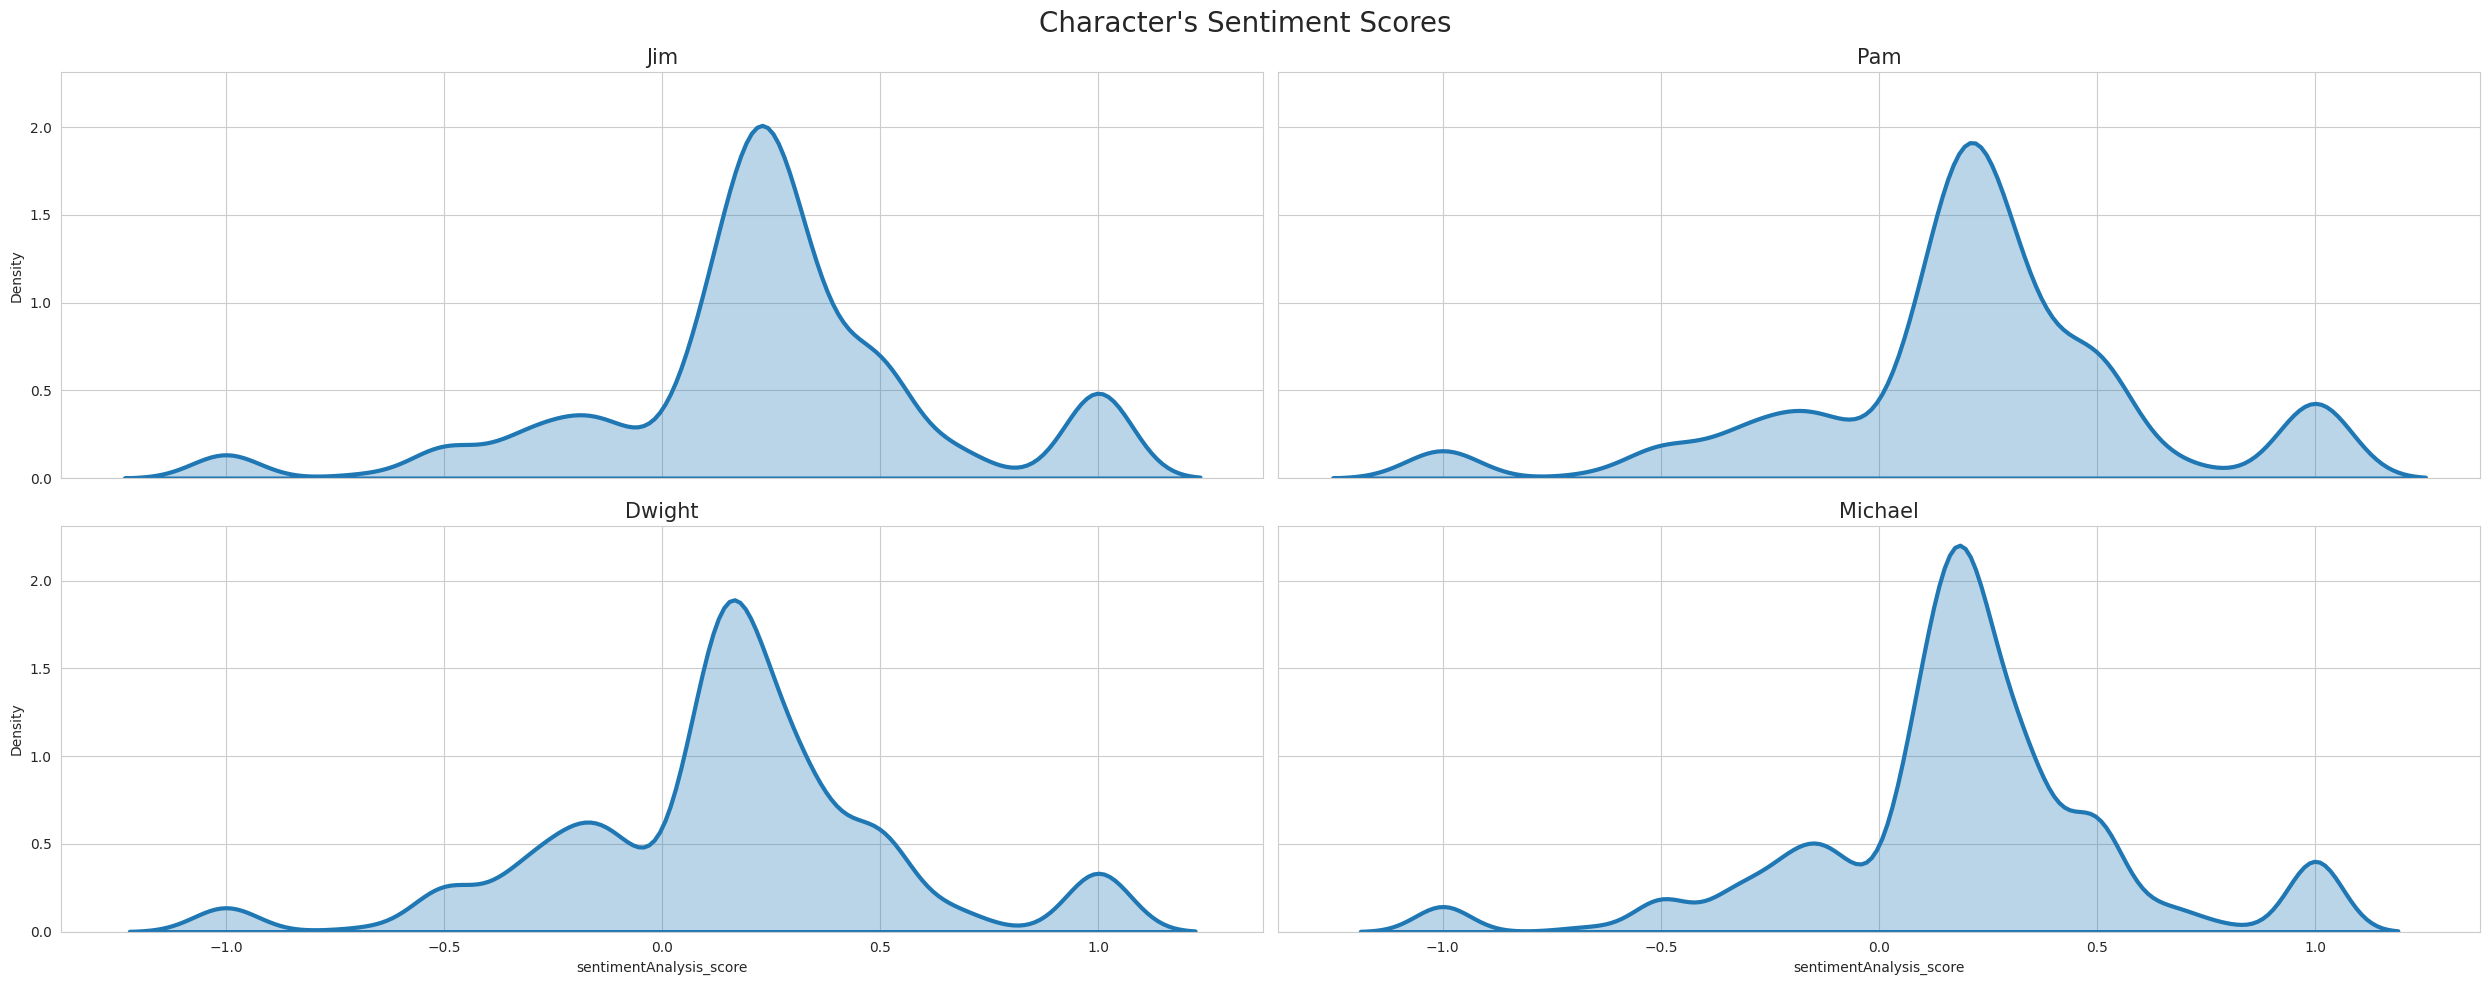

In [6]:
# @title
#density plot with all character's individual sentiment scores
characters = ['Jim', 'Pam', 'Dwight', 'Michael']
fig, axes = plt.subplots(2, 2, figsize = (25, 10), sharex = True, sharey = True)
for ax, character in zip(axes.flatten(), characters):
  sns.kdeplot(data = characters_df[characters_df['character'] == character], x = 'sentimentAnalysis_score', fill = True, alpha = 0.3, linewidth = 3, ax = ax)
  ax.set_title(character, fontsize = 15)
  fig.suptitle("Character's Sentiment Scores", fontsize = 20)
  plt.tight_layout()
plt.show()

                                                      Figure 2
These small multiples are the same plots as Figure 1, except they are taken apart and individually shown, making it easier to focus on each character's sentiment patterns instead of the overall trends. The plots for Pam and Jim have very similar fluctuations, so their sentiment is rather stable and predictable. Furthermore, while comparing Dwight's plot's left tail to Jim and Pam's stable plots, it is visably a lot more jagged and uneven. This uneven plot reveals that Dwight's scores grow at an unstable rate throughout the show, meaning that his emotions have a wide range and are hard to predict. Lastly, Michael's plot falls in between the predictability of Pam/Jim's plots and the unpredictability of Dwight's plot, as his scores tend to fluctate but not as severly as Dwight's scores.

                                                     Hypothesis Testing
I ran a t-test with a null hypothesis of: *Dwight, Jim, Michael, and Pam's sentiment scores do not change throughout the show.* To accomplish this, I ran four different t-tests; one test for each character. I created a dataset holding all of the sentiment scores for those four characters between episodes 1 and 2 in it, and carried out the same process for episodes 23 and 24. By comparing their data from the first 2 episodes to the last 2 episodes, I was able to ascertain if I would reject or fail to reject my null hypothesis. All of the p-values were greater than 0.05, signifying that there was no major development in sentiment scores throughout the show. Pam's p-value was 0.54, Jim's was 0.61, Dwight's was 0.77, and Michael's was 0.33.

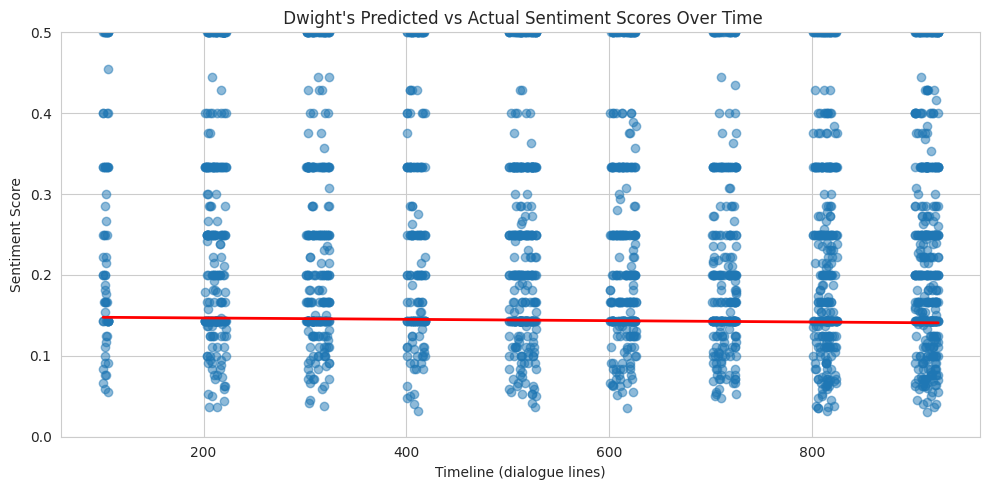

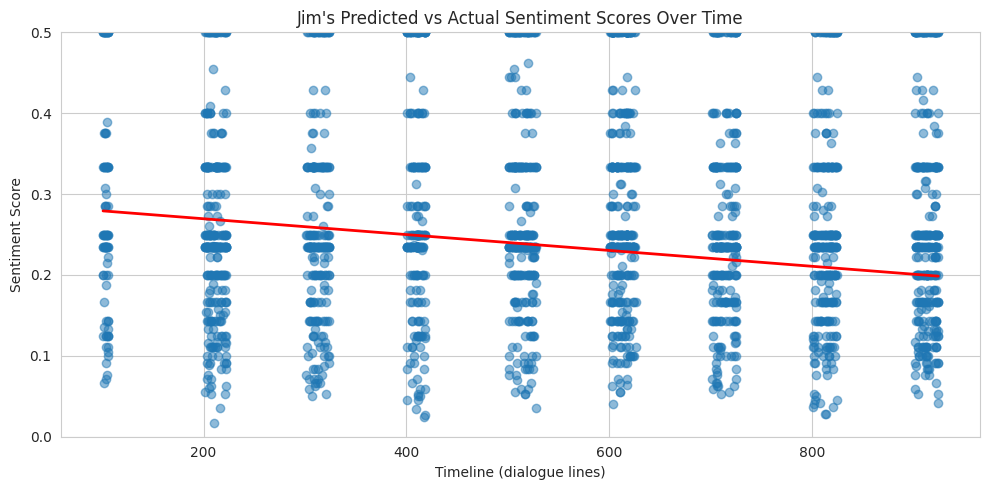

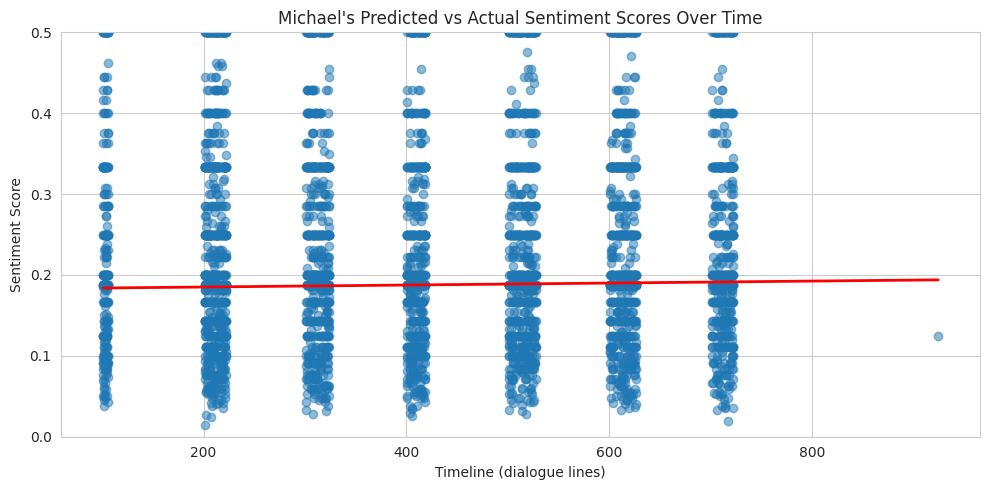

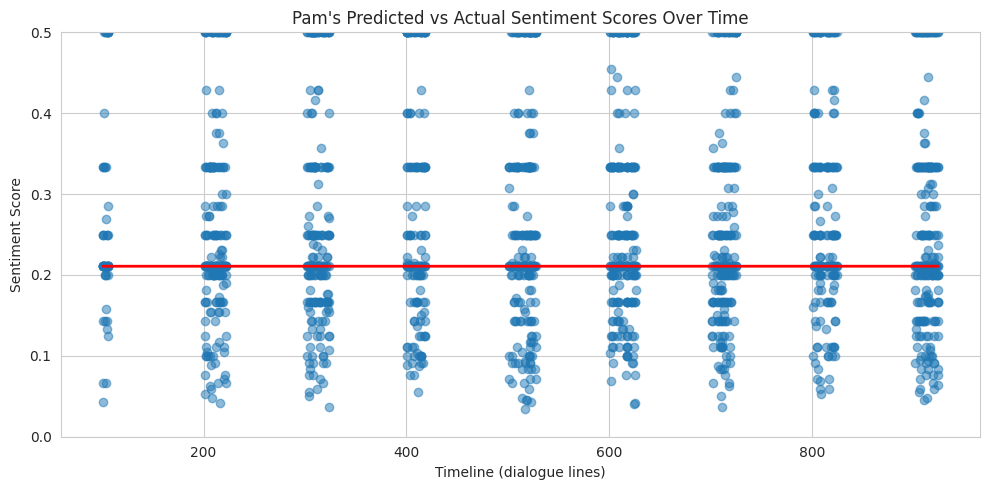

In [8]:
# @title
#getting variables ready for ML model



#Dwight
dwight_sentiment_df = dwight_df['sentimentAnalysis_score']
dwight_df = office_df[office_df['character'] == "Dwight"]
dwight_sentiment_first_df = dwight_sentiment_df.iloc[:1903]
dwight_sentiment_second_df = dwight_sentiment_df.iloc[1904:]

X = (dwight_df['season'] * 100 + dwight_df['episode']).values.reshape(-1, 1) #X is the timeline (combo of season and episode)
y = dwight_sentiment_df.values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

#plotting
plt.figure(figsize = (10, 5))
plt.scatter(X, y, alpha = 0.5, label = 'Actual Sentiment Scores')
plt.plot(X, y_pred, color = 'red', linewidth = 2, label = 'Predicted Sentiment Scores')
plt.title(" Dwight's Predicted vs Actual Sentiment Scores Over Time")
plt.xlabel("Timeline (dialogue lines)")
plt.ylabel("Sentiment Score")
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()








#Jim
jim_sentiment_df = jim_df['sentimentAnalysis_score']
jim_df = office_df[office_df['character'] == "Jim"]
jim_sentiment_first_df = jim_sentiment_df.iloc[:662]
jim_sentiment_second_df = jim_sentiment_df.iloc[663:]

X = (jim_df['season'] * 100 + jim_df['episode']).values.reshape(-1, 1) #X is the timeline (combo of season and episode)
y = jim_sentiment_df.values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

#plotting
plt.figure(figsize = (10, 5))
plt.scatter(X, y, alpha = 0.5, label = 'Actual Sentiment Scores')
plt.plot(X, y_pred, color = 'red', linewidth = 2, label = 'Predicted Sentiment Scores')
plt.title("Jim's Predicted vs Actual Sentiment Scores Over Time")
plt.xlabel("Timeline (dialogue lines)")
plt.ylabel("Sentiment Score")
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()







#Michael
michael_sentiment_df = michael_df['sentimentAnalysis_score']
michael_df = office_df[office_df['character'] == 'Michael']
michael_sentiment_first_df = michael_sentiment_df.iloc[:3261]
michael_sentiment_second_df = michael_sentiment_df.iloc[3262:]

X = (michael_df['season'] * 100 + michael_df['episode']).values.reshape(-1, 1) #X is the timeline (combo of season and episode)
y = michael_sentiment_df.values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

#plotting
plt.figure(figsize = (10, 5))
plt.scatter(X, y, alpha = 0.5, label = 'Actual Sentiment Scores')
plt.plot(X, y_pred, color = 'red', linewidth = 2, label = 'Predicted Sentiment Scores')
plt.title("Michael's Predicted vs Actual Sentiment Scores Over Time")
plt.xlabel("Timeline (dialogue lines)")
plt.ylabel("Sentiment Score")
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()







#Dwight
dwight_sentiment_df = dwight_df['sentimentAnalysis_score']
dwight_df = office_df[office_df['character'] == "Dwight"]
dwight_sentiment_first_df = dwight_sentiment_df.iloc[:1903]
dwight_sentiment_second_df = dwight_sentiment_df.iloc[1904:]

X = (dwight_df['season'] * 100 + dwight_df['episode']).values.reshape(-1, 1) #X is the timeline (combo of season and episode)
y = dwight_sentiment_df.values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

#plotting
plt.figure(figsize = (10, 5))
plt.scatter(X, y, alpha = 0.5, label = 'Actual Sentiment Scores')
plt.plot(X, y_pred, color = 'red', linewidth = 2, label = 'Predicted Sentiment Scores')
plt.title(" Dwight's Predicted vs Actual Sentiment Scores Over Time")
plt.xlabel("Timeline (dialogue lines)")
plt.ylabel("Sentiment Score")
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()




#Pam
pam_df = office_df[office_df['character'] == "Pam"]
pam_sentiment_df = pam_df['sentimentAnalysis_score']
pam_sentiment_first_df = pam_sentiment_df.iloc[:1327]
pam_sentiment_second_df = pam_sentiment_df.iloc[1328:]

X = (pam_df['season'] * 100 + pam_df['episode']).values.reshape(-1, 1) #X is the timeline (the number of times she has a line
y = pam_sentiment_df.values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

#plotting
plt.figure(figsize = (10, 5))
plt.scatter(X, y, alpha = 0.5, label = 'Actual Sentiment Scores')
plt.plot(X, y_pred, color = 'red', linewidth = 2, label = 'Predicted Sentiment Scores')
plt.title("Pam's Predicted vs Actual Sentiment Scores Over Time")
plt.xlabel("Timeline (dialogue lines)")
plt.ylabel("Sentiment Score")
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()



I made four machine learning models, which correspond to the four main characters of *The Office*: Dwight, Jim, Michael, and Pam. Dwight's line of best fit shows very minimal change over the course of the TV show, which conveys that Dwight's mood/sentiment has had little change. Unlike Dwight, Jim's line of best fit displays a decrease in his sentiment scores as the show progresses. This decrease, although quite visable on the plot, is actually a very small decrease, as it is decreasing from 0.3 to 0.2 on a scale where 1 is the best possible score and -1 is the worst possible score. Even though Jim's sentiment decreases over time, his scores still stay in the neutral zone. Instead of decreasing like Jim's line of best fit, Michael's linear regression model's line of best fit increasing slightly as the show progresses. Lastly, the results of Pam's machine learning model is similar to that of Dwight's. She has minimal development in her sentiment scores, and an overall neutral score that is leaning towards the positive side, as it is closer to 1 than -1.

By looking at all of these components, I am able to view the correlation between the patterns located in the machine learning models to that of the density plots. Dwight's density plot's fluctations guided me to the conclusion that his sentiment scores are unstable, and his machine learning model contained a very flat trend line, revealing that his sentiment score is often unstable throughout the TV show. Unlike Dwight, Jim has a relatively positive score, yet that score tends to slightly decrease as the show progresses, as his linear regression machine learning model displays a trend line that decreases over time. The results of his density plot show that the majority of his sentiment scores are closer to 1 than -1, meaning he had more positive scores associated with him than negative. So although his sentiment score decreases over time, he still maintains an overall positive score.
Furthermore, the results between Michael's machine learning model and his density plot reveal what was proved in my t-test; he has no major emotional development. His score tends to have a small increase as the show continues, and despite having a relatively positive score, there is not a large amount of fluctations. Similar to Michael, Pam had an even smaller amount of emotional development. Her density plot showed that the progression of her scores were relatively stable, and her machine learning model's flat trend line shows that she had very little development. This brought me to the conclusion that her sentiment score mainly stays stable throughout the show.

Although I found that no major developments in the main characters emotions, I was still able to see how their scores develop, even if the result of examining these sentiment scores showed little development. Despite there being smaller emotional development in these four characters as I had hoped, the trends in their data exposed me to the wide range of emotional behavior between Dwight, Jim, Michael, and Pam. A character can have an unstable- therefore unpredictable- emotional state, whereas another character can have opposite tendancies for emotional behavior.

I wouldn't have been able to conduct this research if it wasn't for the wonderful dataset made by Derek Sollberger. I have attached both the link to the dataset and the link to my GitHub repository where I stored this project:

Link to dataset: https://raw.githubusercontent.com/dsollberger/quartoblog/master/posts/office_sentiment/office_sentiment.csv

Link to my GitHub respository: https://colab.research.google.com/drive/1wXzMjJu9rqCILcTooZglp629X_3RR6V3#scrollTo=CTdEQ7yuEh5c

I would like to acknowledge my instructor, Sarah Parker, for her thoughtful teaching and guidence. I also want to acknowledge my mentor, Derek Sollberger, for guiding me through the process of creating my project.